<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[21:13:18] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


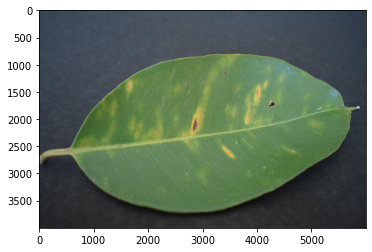

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

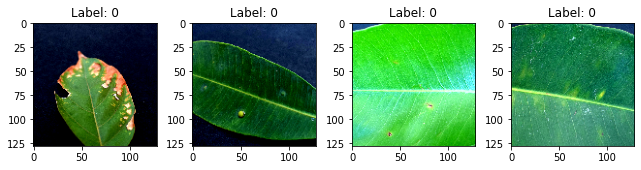

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[21:13:25] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[21:13:27] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2740385393025235 samples/sec                   batch loss = 1.6308823823928833 | accuracy = 0.6


Epoch[1] Batch[10] Speed: 1.280880879230147 samples/sec                   batch loss = 0.5596328377723694 | accuracy = 0.575


Epoch[1] Batch[15] Speed: 1.2917932110314962 samples/sec                   batch loss = 0.6020014882087708 | accuracy = 0.5666666666666667


Epoch[1] Batch[20] Speed: 1.2841416782613235 samples/sec                   batch loss = 0.8083896040916443 | accuracy = 0.5625


Epoch[1] Batch[25] Speed: 1.2853523660383892 samples/sec                   batch loss = 0.1528352051973343 | accuracy = 0.63


Epoch[1] Batch[30] Speed: 1.294922751755305 samples/sec                   batch loss = 0.9158549308776855 | accuracy = 0.6333333333333333


Epoch[1] Batch[35] Speed: 1.2810665128928136 samples/sec                   batch loss = 0.787129819393158 | accuracy = 0.6357142857142857


Epoch[1] Batch[40] Speed: 1.2868281257106822 samples/sec                   batch loss = 1.0698412656784058 | accuracy = 0.6375


Epoch[1] Batch[45] Speed: 1.282160280428542 samples/sec                   batch loss = 0.2734425961971283 | accuracy = 0.6444444444444445


Epoch[1] Batch[50] Speed: 1.2882262611259445 samples/sec                   batch loss = 0.455314576625824 | accuracy = 0.64


Epoch[1] Batch[55] Speed: 1.2842943396012654 samples/sec                   batch loss = 0.1702936589717865 | accuracy = 0.65


Epoch[1] Batch[60] Speed: 1.2905308546516512 samples/sec                   batch loss = 0.5506401658058167 | accuracy = 0.6541666666666667


Epoch[1] Batch[65] Speed: 1.2854229762510494 samples/sec                   batch loss = 1.1091184616088867 | accuracy = 0.6615384615384615


Epoch[1] Batch[70] Speed: 1.2876466792735761 samples/sec                   batch loss = 0.6316749453544617 | accuracy = 0.6678571428571428


Epoch[1] Batch[75] Speed: 1.2854056430397027 samples/sec                   batch loss = 0.263855516910553 | accuracy = 0.6633333333333333


Epoch[1] Batch[80] Speed: 1.2843232441601249 samples/sec                   batch loss = 1.2559843063354492 | accuracy = 0.6625


Epoch[1] Batch[85] Speed: 1.2808584855495875 samples/sec                   batch loss = 1.1048002243041992 | accuracy = 0.6676470588235294


Epoch[1] Batch[90] Speed: 1.2832972413021342 samples/sec                   batch loss = 1.2223924398422241 | accuracy = 0.6694444444444444


Epoch[1] Batch[95] Speed: 1.2849798459055035 samples/sec                   batch loss = 0.9010726809501648 | accuracy = 0.6684210526315789


Epoch[1] Batch[100] Speed: 1.282600781522469 samples/sec                   batch loss = 1.0588654279708862 | accuracy = 0.6675


Epoch[1] Batch[105] Speed: 1.289003711379366 samples/sec                   batch loss = 0.41930529475212097 | accuracy = 0.6642857142857143


Epoch[1] Batch[110] Speed: 1.280757185930922 samples/sec                   batch loss = 1.183745265007019 | accuracy = 0.6590909090909091


Epoch[1] Batch[115] Speed: 1.2700149300721084 samples/sec                   batch loss = 0.617011308670044 | accuracy = 0.6630434782608695


Epoch[1] Batch[120] Speed: 1.2876860134323793 samples/sec                   batch loss = 0.3499686121940613 | accuracy = 0.6645833333333333


Epoch[1] Batch[125] Speed: 1.2866977550070664 samples/sec                   batch loss = 1.4693348407745361 | accuracy = 0.664


Epoch[1] Batch[130] Speed: 1.2887494398233121 samples/sec                   batch loss = 0.9132255911827087 | accuracy = 0.6634615384615384


Epoch[1] Batch[135] Speed: 1.2922948039510729 samples/sec                   batch loss = 0.61277174949646 | accuracy = 0.6648148148148149


Epoch[1] Batch[140] Speed: 1.2900017653966267 samples/sec                   batch loss = 0.6190176606178284 | accuracy = 0.6660714285714285


Epoch[1] Batch[145] Speed: 1.2889195371780546 samples/sec                   batch loss = 0.4183536469936371 | accuracy = 0.6689655172413793


Epoch[1] Batch[150] Speed: 1.2962260659616591 samples/sec                   batch loss = 0.3883803188800812 | accuracy = 0.665


Epoch[1] Batch[155] Speed: 1.2837801739359327 samples/sec                   batch loss = 0.3467608094215393 | accuracy = 0.6693548387096774


Epoch[1] Batch[160] Speed: 1.2854190368437863 samples/sec                   batch loss = 0.8293652534484863 | accuracy = 0.6734375


Epoch[1] Batch[165] Speed: 1.2874168498035827 samples/sec                   batch loss = 0.4737219214439392 | accuracy = 0.6742424242424242


Epoch[1] Batch[170] Speed: 1.28842639829365 samples/sec                   batch loss = 0.7122377157211304 | accuracy = 0.6720588235294118


Epoch[1] Batch[175] Speed: 1.2876657530755988 samples/sec                   batch loss = 0.6472020745277405 | accuracy = 0.6671428571428571


Epoch[1] Batch[180] Speed: 1.2891747674163332 samples/sec                   batch loss = 0.5001131296157837 | accuracy = 0.6694444444444444


Epoch[1] Batch[185] Speed: 1.2935188270602165 samples/sec                   batch loss = 0.5340131521224976 | accuracy = 0.6662162162162162


Epoch[1] Batch[190] Speed: 1.2866452588994182 samples/sec                   batch loss = 0.5631994009017944 | accuracy = 0.6657894736842105


Epoch[1] Batch[195] Speed: 1.2923271556828617 samples/sec                   batch loss = 0.4593977928161621 | accuracy = 0.6628205128205128


Epoch[1] Batch[200] Speed: 1.2962235622703902 samples/sec                   batch loss = 0.6979032754898071 | accuracy = 0.6625


Epoch[1] Batch[205] Speed: 1.282839193891571 samples/sec                   batch loss = 0.3434508442878723 | accuracy = 0.6560975609756098


Epoch[1] Batch[210] Speed: 1.2870041335183817 samples/sec                   batch loss = 0.7026633024215698 | accuracy = 0.655952380952381


Epoch[1] Batch[215] Speed: 1.2905752297516646 samples/sec                   batch loss = 0.4960359036922455 | accuracy = 0.6569767441860465


Epoch[1] Batch[220] Speed: 1.2816914901272751 samples/sec                   batch loss = 0.5852824449539185 | accuracy = 0.6568181818181819


Epoch[1] Batch[225] Speed: 1.2967918476846878 samples/sec                   batch loss = 0.5895652770996094 | accuracy = 0.6555555555555556


Epoch[1] Batch[230] Speed: 1.2795785567756957 samples/sec                   batch loss = 0.686835765838623 | accuracy = 0.6565217391304348


Epoch[1] Batch[235] Speed: 1.2676688755822856 samples/sec                   batch loss = 0.47961610555648804 | accuracy = 0.6606382978723404


Epoch[1] Batch[240] Speed: 1.2887920094541436 samples/sec                   batch loss = 0.5463691353797913 | accuracy = 0.6625


Epoch[1] Batch[245] Speed: 1.2891597102858898 samples/sec                   batch loss = 0.5616626143455505 | accuracy = 0.6612244897959184


Epoch[1] Batch[250] Speed: 1.2932874949489437 samples/sec                   batch loss = 0.4350646734237671 | accuracy = 0.662


Epoch[1] Batch[255] Speed: 1.2907002310567541 samples/sec                   batch loss = 0.6944954991340637 | accuracy = 0.6637254901960784


Epoch[1] Batch[260] Speed: 1.2993492727006026 samples/sec                   batch loss = 0.5835773348808289 | accuracy = 0.6605769230769231


Epoch[1] Batch[265] Speed: 1.2894463514372028 samples/sec                   batch loss = 0.542502760887146 | accuracy = 0.6650943396226415


Epoch[1] Batch[270] Speed: 1.2946180864082593 samples/sec                   batch loss = 0.8980801105499268 | accuracy = 0.6657407407407407


Epoch[1] Batch[275] Speed: 1.293509751698206 samples/sec                   batch loss = 0.11764077097177505 | accuracy = 0.6654545454545454


Epoch[1] Batch[280] Speed: 1.2963536668750089 samples/sec                   batch loss = 0.44603589177131653 | accuracy = 0.6651785714285714


Epoch[1] Batch[285] Speed: 1.2914845484180768 samples/sec                   batch loss = 0.21612001955509186 | accuracy = 0.6657894736842105


Epoch[1] Batch[290] Speed: 1.2890297580947099 samples/sec                   batch loss = 0.30879488587379456 | accuracy = 0.6672413793103448


Epoch[1] Batch[295] Speed: 1.285686675976031 samples/sec                   batch loss = 0.27513623237609863 | accuracy = 0.6677966101694915


Epoch[1] Batch[300] Speed: 1.2846824967651718 samples/sec                   batch loss = 0.5171226263046265 | accuracy = 0.6666666666666666


Epoch[1] Batch[305] Speed: 1.2815956389795309 samples/sec                   batch loss = 0.7283531427383423 | accuracy = 0.6663934426229509


Epoch[1] Batch[310] Speed: 1.282153029493649 samples/sec                   batch loss = 0.27867841720581055 | accuracy = 0.6685483870967742


Epoch[1] Batch[315] Speed: 1.2896526177028276 samples/sec                   batch loss = 0.1872635930776596 | accuracy = 0.6682539682539682


Epoch[1] Batch[320] Speed: 1.2867991082950572 samples/sec                   batch loss = 0.9704349040985107 | accuracy = 0.6671875


Epoch[1] Batch[325] Speed: 1.2885744388893932 samples/sec                   batch loss = 0.511940598487854 | accuracy = 0.6661538461538462


Epoch[1] Batch[330] Speed: 1.2874217893850497 samples/sec                   batch loss = 0.33066439628601074 | accuracy = 0.6643939393939394


Epoch[1] Batch[335] Speed: 1.2897930076852284 samples/sec                   batch loss = 0.3053700029850006 | accuracy = 0.6656716417910448


Epoch[1] Batch[340] Speed: 1.287777637737931 samples/sec                   batch loss = 1.0221247673034668 | accuracy = 0.6676470588235294


Epoch[1] Batch[345] Speed: 1.2820587748025547 samples/sec                   batch loss = 0.2779737114906311 | accuracy = 0.6702898550724637


Epoch[1] Batch[350] Speed: 1.2937371727768878 samples/sec                   batch loss = 0.3989596664905548 | accuracy = 0.6721428571428572


Epoch[1] Batch[355] Speed: 1.2859979946446696 samples/sec                   batch loss = 0.4688907563686371 | accuracy = 0.6732394366197183


Epoch[1] Batch[360] Speed: 1.2709795476971038 samples/sec                   batch loss = 0.3328237533569336 | accuracy = 0.6743055555555556


Epoch[1] Batch[365] Speed: 1.282324330248875 samples/sec                   batch loss = 0.7334943413734436 | accuracy = 0.6746575342465754


Epoch[1] Batch[370] Speed: 1.2918761693688916 samples/sec                   batch loss = 0.5844328999519348 | accuracy = 0.677027027027027


Epoch[1] Batch[375] Speed: 1.2963829164631557 samples/sec                   batch loss = 0.7055090665817261 | accuracy = 0.6786666666666666


Epoch[1] Batch[380] Speed: 1.2975973373029799 samples/sec                   batch loss = 0.6612695455551147 | accuracy = 0.6782894736842106


Epoch[1] Batch[385] Speed: 1.298682732959295 samples/sec                   batch loss = 0.8015367388725281 | accuracy = 0.6779220779220779


Epoch[1] Batch[390] Speed: 1.2868865593075862 samples/sec                   batch loss = 0.2828790247440338 | accuracy = 0.6782051282051282


Epoch[1] Batch[395] Speed: 1.2864707302730338 samples/sec                   batch loss = 0.25984421372413635 | accuracy = 0.6791139240506329


Epoch[1] Batch[400] Speed: 1.281362777490098 samples/sec                   batch loss = 0.5799897909164429 | accuracy = 0.678125


Epoch[1] Batch[405] Speed: 1.2830094025476015 samples/sec                   batch loss = 0.6793689727783203 | accuracy = 0.678395061728395


Epoch[1] Batch[410] Speed: 1.291148309911931 samples/sec                   batch loss = 0.6441108584403992 | accuracy = 0.6780487804878049


Epoch[1] Batch[415] Speed: 1.2933004553358036 samples/sec                   batch loss = 0.29169848561286926 | accuracy = 0.6789156626506024


Epoch[1] Batch[420] Speed: 1.282357654935351 samples/sec                   batch loss = 0.2790420651435852 | accuracy = 0.6803571428571429


Epoch[1] Batch[425] Speed: 1.27978509468129 samples/sec                   batch loss = 0.40493130683898926 | accuracy = 0.6823529411764706


Epoch[1] Batch[430] Speed: 1.2867018009375155 samples/sec                   batch loss = 0.41574031114578247 | accuracy = 0.6843023255813954


Epoch[1] Batch[435] Speed: 1.2900484848065432 samples/sec                   batch loss = 0.796737015247345 | accuracy = 0.6856321839080459


Epoch[1] Batch[440] Speed: 1.2851760221123727 samples/sec                   batch loss = 0.25121960043907166 | accuracy = 0.6863636363636364


Epoch[1] Batch[445] Speed: 1.282447346150915 samples/sec                   batch loss = 0.5704518556594849 | accuracy = 0.6848314606741573


Epoch[1] Batch[450] Speed: 1.2831304891037414 samples/sec                   batch loss = 0.3017778992652893 | accuracy = 0.6855555555555556


Epoch[1] Batch[455] Speed: 1.2819770724901822 samples/sec                   batch loss = 0.5261885523796082 | accuracy = 0.6857142857142857


Epoch[1] Batch[460] Speed: 1.2885918576666964 samples/sec                   batch loss = 0.4524509608745575 | accuracy = 0.6858695652173913


Epoch[1] Batch[465] Speed: 1.2901733840895993 samples/sec                   batch loss = 0.40960434079170227 | accuracy = 0.6870967741935484


Epoch[1] Batch[470] Speed: 1.2896993118258608 samples/sec                   batch loss = 0.30993714928627014 | accuracy = 0.6872340425531915


Epoch[1] Batch[475] Speed: 1.2900047410543163 samples/sec                   batch loss = 0.4425567388534546 | accuracy = 0.6863157894736842


Epoch[1] Batch[480] Speed: 1.267181140974032 samples/sec                   batch loss = 1.9021655321121216 | accuracy = 0.6848958333333334


Epoch[1] Batch[485] Speed: 1.2717925175717286 samples/sec                   batch loss = 0.7382649183273315 | accuracy = 0.6835051546391753


Epoch[1] Batch[490] Speed: 1.2840072326552578 samples/sec                   batch loss = 0.5939265489578247 | accuracy = 0.6836734693877551


Epoch[1] Batch[495] Speed: 1.290133004948458 samples/sec                   batch loss = 0.6971074342727661 | accuracy = 0.6833333333333333


Epoch[1] Batch[500] Speed: 1.282009399498237 samples/sec                   batch loss = 0.40498873591423035 | accuracy = 0.6855


Epoch[1] Batch[505] Speed: 1.2852642372571679 samples/sec                   batch loss = 0.31042659282684326 | accuracy = 0.6866336633663367


Epoch[1] Batch[510] Speed: 1.2821251043618975 samples/sec                   batch loss = 0.8653217554092407 | accuracy = 0.6848039215686275


Epoch[1] Batch[515] Speed: 1.277454486368182 samples/sec                   batch loss = 0.5767368078231812 | accuracy = 0.6849514563106797


Epoch[1] Batch[520] Speed: 1.28848606564459 samples/sec                   batch loss = 0.4149297773838043 | accuracy = 0.6870192307692308


Epoch[1] Batch[525] Speed: 1.2881978729997754 samples/sec                   batch loss = 0.4304845631122589 | accuracy = 0.6880952380952381


Epoch[1] Batch[530] Speed: 1.2822864990276546 samples/sec                   batch loss = 0.6490412354469299 | accuracy = 0.6872641509433962


Epoch[1] Batch[535] Speed: 1.281124522218943 samples/sec                   batch loss = 0.21608994901180267 | accuracy = 0.6878504672897197


Epoch[1] Batch[540] Speed: 1.2810820663113505 samples/sec                   batch loss = 0.40084412693977356 | accuracy = 0.6902777777777778


Epoch[1] Batch[545] Speed: 1.276406989115113 samples/sec                   batch loss = 0.27136674523353577 | accuracy = 0.6908256880733945


Epoch[1] Batch[550] Speed: 1.2820445692161808 samples/sec                   batch loss = 0.3587570786476135 | accuracy = 0.6922727272727273


Epoch[1] Batch[555] Speed: 1.2778202222938333 samples/sec                   batch loss = 1.0135506391525269 | accuracy = 0.6923423423423424


Epoch[1] Batch[560] Speed: 1.2819075259694297 samples/sec                   batch loss = 0.3337967097759247 | accuracy = 0.69375


Epoch[1] Batch[565] Speed: 1.273716060709702 samples/sec                   batch loss = 0.14285939931869507 | accuracy = 0.6938053097345133


Epoch[1] Batch[570] Speed: 1.276367564172458 samples/sec                   batch loss = 0.4461376368999481 | accuracy = 0.6942982456140351


Epoch[1] Batch[575] Speed: 1.273603415463261 samples/sec                   batch loss = 0.3450549244880676 | accuracy = 0.6956521739130435


Epoch[1] Batch[580] Speed: 1.2802528819817696 samples/sec                   batch loss = 0.535044252872467 | accuracy = 0.6961206896551724


Epoch[1] Batch[585] Speed: 1.2805128030168942 samples/sec                   batch loss = 0.5083903670310974 | accuracy = 0.697008547008547


Epoch[1] Batch[590] Speed: 1.2806545337464574 samples/sec                   batch loss = 0.3131037652492523 | accuracy = 0.6978813559322034


Epoch[1] Batch[595] Speed: 1.2858745923204606 samples/sec                   batch loss = 0.38764750957489014 | accuracy = 0.6987394957983193


Epoch[1] Batch[600] Speed: 1.2660095856903595 samples/sec                   batch loss = 0.30362313985824585 | accuracy = 0.6995833333333333


Epoch[1] Batch[605] Speed: 1.2628603550506086 samples/sec                   batch loss = 0.5905905961990356 | accuracy = 0.7004132231404959


Epoch[1] Batch[610] Speed: 1.2721969809047033 samples/sec                   batch loss = 0.6043794751167297 | accuracy = 0.7


Epoch[1] Batch[615] Speed: 1.2577688171660106 samples/sec                   batch loss = 0.829230010509491 | accuracy = 0.6991869918699187


Epoch[1] Batch[620] Speed: 1.2648939781884934 samples/sec                   batch loss = 0.2650713622570038 | accuracy = 0.7004032258064516


Epoch[1] Batch[625] Speed: 1.284024331630201 samples/sec                   batch loss = 0.2997331917285919 | accuracy = 0.7028


Epoch[1] Batch[630] Speed: 1.2851205984784038 samples/sec                   batch loss = 0.32771390676498413 | accuracy = 0.7031746031746032


Epoch[1] Batch[635] Speed: 1.292841915372615 samples/sec                   batch loss = 0.7383432984352112 | accuracy = 0.7023622047244095


Epoch[1] Batch[640] Speed: 1.2845167612464208 samples/sec                   batch loss = 0.78264981508255 | accuracy = 0.70234375


Epoch[1] Batch[645] Speed: 1.2846325257080167 samples/sec                   batch loss = 0.6701082587242126 | accuracy = 0.7015503875968992


Epoch[1] Batch[650] Speed: 1.2808133094157614 samples/sec                   batch loss = 0.6124680638313293 | accuracy = 0.7026923076923077


Epoch[1] Batch[655] Speed: 1.2794175503141232 samples/sec                   batch loss = 0.4196201264858246 | accuracy = 0.7034351145038168


Epoch[1] Batch[660] Speed: 1.286858723722882 samples/sec                   batch loss = 0.23840191960334778 | accuracy = 0.7037878787878787


Epoch[1] Batch[665] Speed: 1.2869989009598939 samples/sec                   batch loss = 0.23400206863880157 | accuracy = 0.7045112781954888


Epoch[1] Batch[670] Speed: 1.290745908741277 samples/sec                   batch loss = 1.4576942920684814 | accuracy = 0.7048507462686567


Epoch[1] Batch[675] Speed: 1.2892184548972996 samples/sec                   batch loss = 0.2488241195678711 | accuracy = 0.7062962962962963


Epoch[1] Batch[680] Speed: 1.2869398648519594 samples/sec                   batch loss = 0.5418856739997864 | accuracy = 0.7058823529411765


Epoch[1] Batch[685] Speed: 1.284296502482403 samples/sec                   batch loss = 0.38258740305900574 | accuracy = 0.7065693430656934


Epoch[1] Batch[690] Speed: 1.2842932581634283 samples/sec                   batch loss = 0.371762216091156 | accuracy = 0.7079710144927536


Epoch[1] Batch[695] Speed: 1.2878765908164689 samples/sec                   batch loss = 0.785437822341919 | accuracy = 0.7068345323741008


Epoch[1] Batch[700] Speed: 1.286993273538817 samples/sec                   batch loss = 0.21260783076286316 | accuracy = 0.7082142857142857


Epoch[1] Batch[705] Speed: 1.2867261757398216 samples/sec                   batch loss = 0.5943076610565186 | accuracy = 0.7085106382978723


Epoch[1] Batch[710] Speed: 1.288849730445124 samples/sec                   batch loss = 0.7270936369895935 | accuracy = 0.7080985915492958


Epoch[1] Batch[715] Speed: 1.284685349560933 samples/sec                   batch loss = 0.38822588324546814 | accuracy = 0.708041958041958


Epoch[1] Batch[720] Speed: 1.2862961503692045 samples/sec                   batch loss = 0.9322832226753235 | accuracy = 0.7072916666666667


Epoch[1] Batch[725] Speed: 1.2873954124592366 samples/sec                   batch loss = 0.7964715957641602 | accuracy = 0.706551724137931


Epoch[1] Batch[730] Speed: 1.292661020596555 samples/sec                   batch loss = 0.7811946272850037 | accuracy = 0.7061643835616438


Epoch[1] Batch[735] Speed: 1.2950129098242025 samples/sec                   batch loss = 0.38781899213790894 | accuracy = 0.7068027210884353


Epoch[1] Batch[740] Speed: 1.2689141367558254 samples/sec                   batch loss = 0.6521410942077637 | accuracy = 0.706418918918919


Epoch[1] Batch[745] Speed: 1.2667600610501477 samples/sec                   batch loss = 0.3366653621196747 | accuracy = 0.7077181208053691


Epoch[1] Batch[750] Speed: 1.2670452472896554 samples/sec                   batch loss = 0.5698792934417725 | accuracy = 0.7073333333333334


Epoch[1] Batch[755] Speed: 1.2788921705852643 samples/sec                   batch loss = 1.9650121927261353 | accuracy = 0.7082781456953643


Epoch[1] Batch[760] Speed: 1.2638496423231784 samples/sec                   batch loss = 0.5745565295219421 | accuracy = 0.7082236842105263


Epoch[1] Batch[765] Speed: 1.2583491784383964 samples/sec                   batch loss = 1.2057374715805054 | accuracy = 0.7084967320261438


Epoch[1] Batch[770] Speed: 1.2712111545694669 samples/sec                   batch loss = 0.9518555998802185 | accuracy = 0.7081168831168831


Epoch[1] Batch[775] Speed: 1.2584109063374653 samples/sec                   batch loss = 0.8714833855628967 | accuracy = 0.7074193548387097


Epoch[1] Batch[780] Speed: 1.2637150333301772 samples/sec                   batch loss = 1.0152806043624878 | accuracy = 0.7083333333333334


Epoch[1] Batch[785] Speed: 1.2769461704514335 samples/sec                   batch loss = 0.60556960105896 | accuracy = 0.7085987261146497


[Epoch 1] training: accuracy=0.708756345177665
[Epoch 1] time cost: 640.0948765277863
[Epoch 1] validation: validation accuracy=0.6622222222222223


Epoch[2] Batch[5] Speed: 1.2870678161777516 samples/sec                   batch loss = 0.3780311644077301 | accuracy = 0.7


Epoch[2] Batch[10] Speed: 1.2906655777529261 samples/sec                   batch loss = 0.47249338030815125 | accuracy = 0.7


Epoch[2] Batch[15] Speed: 1.2950103108571365 samples/sec                   batch loss = 0.23590171337127686 | accuracy = 0.7166666666666667


Epoch[2] Batch[20] Speed: 1.2781144029076366 samples/sec                   batch loss = 0.46172088384628296 | accuracy = 0.75


Epoch[2] Batch[25] Speed: 1.266196476114236 samples/sec                   batch loss = 0.41039904952049255 | accuracy = 0.75


Epoch[2] Batch[30] Speed: 1.271558096769502 samples/sec                   batch loss = 0.44557154178619385 | accuracy = 0.7333333333333333


Epoch[2] Batch[35] Speed: 1.291071902937145 samples/sec                   batch loss = 0.359565407037735 | accuracy = 0.75


Epoch[2] Batch[40] Speed: 1.2879431282589677 samples/sec                   batch loss = 0.3269577920436859 | accuracy = 0.75


Epoch[2] Batch[45] Speed: 1.2832855603664228 samples/sec                   batch loss = 0.4381272494792938 | accuracy = 0.7555555555555555


Epoch[2] Batch[50] Speed: 1.2875621881383719 samples/sec                   batch loss = 0.35556745529174805 | accuracy = 0.765


Epoch[2] Batch[55] Speed: 1.2835374838307114 samples/sec                   batch loss = 0.2035244107246399 | accuracy = 0.7636363636363637


Epoch[2] Batch[60] Speed: 1.281545809879623 samples/sec                   batch loss = 0.7999858856201172 | accuracy = 0.7458333333333333


Epoch[2] Batch[65] Speed: 1.289003711379366 samples/sec                   batch loss = 2.7665517330169678 | accuracy = 0.7423076923076923


Epoch[2] Batch[70] Speed: 1.2827299309863942 samples/sec                   batch loss = 0.5420973300933838 | accuracy = 0.7428571428571429


Epoch[2] Batch[75] Speed: 1.2806394794764078 samples/sec                   batch loss = 0.1467716544866562 | accuracy = 0.75


Epoch[2] Batch[80] Speed: 1.2773151162134706 samples/sec                   batch loss = 1.5333465337753296 | accuracy = 0.7375


Epoch[2] Batch[85] Speed: 1.2806825903760046 samples/sec                   batch loss = 0.3066694438457489 | accuracy = 0.7352941176470589


Epoch[2] Batch[90] Speed: 1.2848230858071112 samples/sec                   batch loss = 0.6666486263275146 | accuracy = 0.7305555555555555


Epoch[2] Batch[95] Speed: 1.2805362597297407 samples/sec                   batch loss = 0.34626325964927673 | accuracy = 0.7315789473684211


Epoch[2] Batch[100] Speed: 1.2863246519868428 samples/sec                   batch loss = 0.590261697769165 | accuracy = 0.7325


Epoch[2] Batch[105] Speed: 1.28241323260362 samples/sec                   batch loss = 0.5976657867431641 | accuracy = 0.7309523809523809


Epoch[2] Batch[110] Speed: 1.2784778863970012 samples/sec                   batch loss = 0.509823203086853 | accuracy = 0.7386363636363636


Epoch[2] Batch[115] Speed: 1.2780308659867399 samples/sec                   batch loss = 0.38040482997894287 | accuracy = 0.7369565217391304


Epoch[2] Batch[120] Speed: 1.2766163899698217 samples/sec                   batch loss = 0.4224632978439331 | accuracy = 0.7333333333333333


Epoch[2] Batch[125] Speed: 1.2838671168344593 samples/sec                   batch loss = 0.6718959212303162 | accuracy = 0.734


Epoch[2] Batch[130] Speed: 1.2783293318592264 samples/sec                   batch loss = 0.3046245276927948 | accuracy = 0.7346153846153847


Epoch[2] Batch[135] Speed: 1.2736762216585638 samples/sec                   batch loss = 0.4828697144985199 | accuracy = 0.7351851851851852


Epoch[2] Batch[140] Speed: 1.2835103820936045 samples/sec                   batch loss = 0.5399380922317505 | accuracy = 0.7321428571428571


Epoch[2] Batch[145] Speed: 1.2593852909715315 samples/sec                   batch loss = 0.7210770845413208 | accuracy = 0.7344827586206897


Epoch[2] Batch[150] Speed: 1.2605374146460284 samples/sec                   batch loss = 0.13811683654785156 | accuracy = 0.7416666666666667


Epoch[2] Batch[155] Speed: 1.2645964144928405 samples/sec                   batch loss = 0.40406566858291626 | accuracy = 0.7435483870967742


Epoch[2] Batch[160] Speed: 1.2749779843615252 samples/sec                   batch loss = 0.7136663794517517 | accuracy = 0.7390625


Epoch[2] Batch[165] Speed: 1.2644383936947865 samples/sec                   batch loss = 0.38202035427093506 | accuracy = 0.740909090909091


Epoch[2] Batch[170] Speed: 1.2625524407427509 samples/sec                   batch loss = 0.12438277155160904 | accuracy = 0.7411764705882353


Epoch[2] Batch[175] Speed: 1.2764379675644224 samples/sec                   batch loss = 1.686025619506836 | accuracy = 0.74


Epoch[2] Batch[180] Speed: 1.2854545908687545 samples/sec                   batch loss = 0.4977072477340698 | accuracy = 0.7361111111111112


Epoch[2] Batch[185] Speed: 1.2834140623559698 samples/sec                   batch loss = 0.3629821836948395 | accuracy = 0.7378378378378379


Epoch[2] Batch[190] Speed: 1.2884309498371607 samples/sec                   batch loss = 0.22598513960838318 | accuracy = 0.7407894736842106


Epoch[2] Batch[195] Speed: 1.2840561723143389 samples/sec                   batch loss = 0.29446226358413696 | accuracy = 0.7397435897435898


Epoch[2] Batch[200] Speed: 1.2860737036383758 samples/sec                   batch loss = 1.40703547000885 | accuracy = 0.74


Epoch[2] Batch[205] Speed: 1.2848507349983718 samples/sec                   batch loss = 0.5317403674125671 | accuracy = 0.7414634146341463


Epoch[2] Batch[210] Speed: 1.2834366436678168 samples/sec                   batch loss = 0.6927788257598877 | accuracy = 0.7428571428571429


Epoch[2] Batch[215] Speed: 1.289109588425348 samples/sec                   batch loss = 0.47968605160713196 | accuracy = 0.7406976744186047


Epoch[2] Batch[220] Speed: 1.2793374524972876 samples/sec                   batch loss = 0.6831002235412598 | accuracy = 0.740909090909091


Epoch[2] Batch[225] Speed: 1.286660257350212 samples/sec                   batch loss = 0.7346058487892151 | accuracy = 0.7388888888888889


Epoch[2] Batch[230] Speed: 1.2803280137229982 samples/sec                   batch loss = 1.5175821781158447 | accuracy = 0.7358695652173913


Epoch[2] Batch[235] Speed: 1.28178001096799 samples/sec                   batch loss = 0.8979264497756958 | accuracy = 0.7351063829787234


Epoch[2] Batch[240] Speed: 1.2795436198102865 samples/sec                   batch loss = 0.4163062572479248 | accuracy = 0.7333333333333333


Epoch[2] Batch[245] Speed: 1.2856067764405572 samples/sec                   batch loss = 0.3124006390571594 | accuracy = 0.7357142857142858


Epoch[2] Batch[250] Speed: 1.2846646916710434 samples/sec                   batch loss = 0.2585638463497162 | accuracy = 0.738


Epoch[2] Batch[255] Speed: 1.2767135379965209 samples/sec                   batch loss = 0.6531354188919067 | accuracy = 0.7372549019607844


Epoch[2] Batch[260] Speed: 1.281191537845332 samples/sec                   batch loss = 1.0273211002349854 | accuracy = 0.7355769230769231


Epoch[2] Batch[265] Speed: 1.280499218063683 samples/sec                   batch loss = 0.26318737864494324 | accuracy = 0.7358490566037735


Epoch[2] Batch[270] Speed: 1.2744739605616273 samples/sec                   batch loss = 0.3495035469532013 | accuracy = 0.7342592592592593


Epoch[2] Batch[275] Speed: 1.2839260678711146 samples/sec                   batch loss = 0.4905634820461273 | accuracy = 0.7354545454545455


Epoch[2] Batch[280] Speed: 1.2844918800211065 samples/sec                   batch loss = 0.5205593705177307 | accuracy = 0.7357142857142858


Epoch[2] Batch[285] Speed: 1.2884111607515862 samples/sec                   batch loss = 0.5237627029418945 | accuracy = 0.7342105263157894


Epoch[2] Batch[290] Speed: 1.2666443394252074 samples/sec                   batch loss = 0.226408913731575 | accuracy = 0.7370689655172413


Epoch[2] Batch[295] Speed: 1.2588487441087657 samples/sec                   batch loss = 0.28336647152900696 | accuracy = 0.738135593220339


Epoch[2] Batch[300] Speed: 1.2699403309069008 samples/sec                   batch loss = 0.3002268075942993 | accuracy = 0.7408333333333333


Epoch[2] Batch[305] Speed: 1.2786392411213379 samples/sec                   batch loss = 0.6676024198532104 | accuracy = 0.740983606557377


Epoch[2] Batch[310] Speed: 1.2861161952731144 samples/sec                   batch loss = 1.0560466051101685 | accuracy = 0.7403225806451613


Epoch[2] Batch[315] Speed: 1.288346652553423 samples/sec                   batch loss = 0.5335831642150879 | accuracy = 0.7412698412698413


Epoch[2] Batch[320] Speed: 1.2922167682858026 samples/sec                   batch loss = 0.22206613421440125 | accuracy = 0.7421875


Epoch[2] Batch[325] Speed: 1.2859913902463367 samples/sec                   batch loss = 0.5736396908760071 | accuracy = 0.7430769230769231


Epoch[2] Batch[330] Speed: 1.2915768135346455 samples/sec                   batch loss = 0.6007567048072815 | accuracy = 0.7401515151515151


Epoch[2] Batch[335] Speed: 1.2866114149958967 samples/sec                   batch loss = 0.3457304537296295 | accuracy = 0.7395522388059701


Epoch[2] Batch[340] Speed: 1.2834705171255465 samples/sec                   batch loss = 0.2089996188879013 | accuracy = 0.7397058823529412


Epoch[2] Batch[345] Speed: 1.2856486461053402 samples/sec                   batch loss = 0.24530750513076782 | accuracy = 0.7420289855072464


Epoch[2] Batch[350] Speed: 1.286305716515272 samples/sec                   batch loss = 1.23378324508667 | accuracy = 0.7392857142857143


Epoch[2] Batch[355] Speed: 1.283268088439339 samples/sec                   batch loss = 0.6408823132514954 | accuracy = 0.7394366197183099


Epoch[2] Batch[360] Speed: 1.28905313170877 samples/sec                   batch loss = 1.0691053867340088 | accuracy = 0.7402777777777778


Epoch[2] Batch[365] Speed: 1.2819934317117092 samples/sec                   batch loss = 0.3857296407222748 | accuracy = 0.7397260273972602


Epoch[2] Batch[370] Speed: 1.282242104094218 samples/sec                   batch loss = 0.3666573166847229 | accuracy = 0.7398648648648649


Epoch[2] Batch[375] Speed: 1.281648409185948 samples/sec                   batch loss = 1.1076847314834595 | accuracy = 0.7413333333333333


Epoch[2] Batch[380] Speed: 1.2891067159466834 samples/sec                   batch loss = 0.3040934205055237 | accuracy = 0.7414473684210526


Epoch[2] Batch[385] Speed: 1.281984713272226 samples/sec                   batch loss = 0.7378870248794556 | accuracy = 0.7402597402597403


Epoch[2] Batch[390] Speed: 1.2862369814935903 samples/sec                   batch loss = 0.19766020774841309 | accuracy = 0.742948717948718


Epoch[2] Batch[395] Speed: 1.288661933415049 samples/sec                   batch loss = 0.23684322834014893 | accuracy = 0.7430379746835443


Epoch[2] Batch[400] Speed: 1.2978970810340122 samples/sec                   batch loss = 0.19215556979179382 | accuracy = 0.745


Epoch[2] Batch[405] Speed: 1.2950273042922227 samples/sec                   batch loss = 0.38636404275894165 | accuracy = 0.745679012345679


Epoch[2] Batch[410] Speed: 1.2992377830860733 samples/sec                   batch loss = 0.325355589389801 | accuracy = 0.7463414634146341


Epoch[2] Batch[415] Speed: 1.275176642792027 samples/sec                   batch loss = 0.8149040341377258 | accuracy = 0.7463855421686747


Epoch[2] Batch[420] Speed: 1.2698833299777015 samples/sec                   batch loss = 0.23869474232196808 | accuracy = 0.7464285714285714


Epoch[2] Batch[425] Speed: 1.2709807031144118 samples/sec                   batch loss = 0.7931249737739563 | accuracy = 0.7458823529411764


Epoch[2] Batch[430] Speed: 1.290637677734452 samples/sec                   batch loss = 0.5684554576873779 | accuracy = 0.7441860465116279


Epoch[2] Batch[435] Speed: 1.2955973424572524 samples/sec                   batch loss = 0.2418104112148285 | accuracy = 0.746551724137931


Epoch[2] Batch[440] Speed: 1.292884257639532 samples/sec                   batch loss = 0.44430986046791077 | accuracy = 0.7465909090909091


Epoch[2] Batch[445] Speed: 1.296197925028389 samples/sec                   batch loss = 0.218591570854187 | accuracy = 0.7471910112359551


Epoch[2] Batch[450] Speed: 1.2914927006237298 samples/sec                   batch loss = 0.46136999130249023 | accuracy = 0.7461111111111111


Epoch[2] Batch[455] Speed: 1.2876722758525836 samples/sec                   batch loss = 0.795333743095398 | accuracy = 0.7456043956043956


Epoch[2] Batch[460] Speed: 1.2920393319525676 samples/sec                   batch loss = 0.44632643461227417 | accuracy = 0.746195652173913


Epoch[2] Batch[465] Speed: 1.2894342609885254 samples/sec                   batch loss = 0.9986360669136047 | accuracy = 0.7462365591397849


Epoch[2] Batch[470] Speed: 1.295521208336541 samples/sec                   batch loss = 0.5218189358711243 | accuracy = 0.7441489361702127


Epoch[2] Batch[475] Speed: 1.2872043848934773 samples/sec                   batch loss = 0.44469061493873596 | accuracy = 0.7452631578947368


Epoch[2] Batch[480] Speed: 1.2910304740676433 samples/sec                   batch loss = 0.42939093708992004 | accuracy = 0.7453125


Epoch[2] Batch[485] Speed: 1.2894018557402545 samples/sec                   batch loss = 0.3014315366744995 | accuracy = 0.7469072164948454


Epoch[2] Batch[490] Speed: 1.2838330259555601 samples/sec                   batch loss = 0.7881004214286804 | accuracy = 0.7459183673469387


Epoch[2] Batch[495] Speed: 1.286598588325731 samples/sec                   batch loss = 0.46140149235725403 | accuracy = 0.7464646464646465


Epoch[2] Batch[500] Speed: 1.28506616393195 samples/sec                   batch loss = 0.38873380422592163 | accuracy = 0.746


Epoch[2] Batch[505] Speed: 1.283189274367605 samples/sec                   batch loss = 0.22053906321525574 | accuracy = 0.747029702970297


Epoch[2] Batch[510] Speed: 1.2839098557963646 samples/sec                   batch loss = 0.34442630410194397 | accuracy = 0.7475490196078431


Epoch[2] Batch[515] Speed: 1.285479607898905 samples/sec                   batch loss = 0.804767370223999 | accuracy = 0.7466019417475728


Epoch[2] Batch[520] Speed: 1.2872457660962535 samples/sec                   batch loss = 0.5202464461326599 | accuracy = 0.7466346153846154


Epoch[2] Batch[525] Speed: 1.2870796648097065 samples/sec                   batch loss = 0.6286267042160034 | accuracy = 0.7471428571428571


Epoch[2] Batch[530] Speed: 1.2849034783927311 samples/sec                   batch loss = 0.20860272645950317 | accuracy = 0.7481132075471698


Epoch[2] Batch[535] Speed: 1.2958382093024028 samples/sec                   batch loss = 0.6954125165939331 | accuracy = 0.7490654205607477


Epoch[2] Batch[540] Speed: 1.283172197625707 samples/sec                   batch loss = 0.1803760826587677 | accuracy = 0.75


Epoch[2] Batch[545] Speed: 1.2715452793740838 samples/sec                   batch loss = 0.5878284573554993 | accuracy = 0.7504587155963303


Epoch[2] Batch[550] Speed: 1.2770049736104006 samples/sec                   batch loss = 0.6701520681381226 | accuracy = 0.7513636363636363


Epoch[2] Batch[555] Speed: 1.2741156527007609 samples/sec                   batch loss = 0.33696985244750977 | accuracy = 0.7518018018018018


Epoch[2] Batch[560] Speed: 1.26971101259001 samples/sec                   batch loss = 0.9008946418762207 | accuracy = 0.7517857142857143


Epoch[2] Batch[565] Speed: 1.2781484828762535 samples/sec                   batch loss = 0.5783326029777527 | accuracy = 0.7522123893805309


Epoch[2] Batch[570] Speed: 1.2942354844144488 samples/sec                   batch loss = 0.33535048365592957 | accuracy = 0.7521929824561403


Epoch[2] Batch[575] Speed: 1.295908374733843 samples/sec                   batch loss = 0.2971686124801636 | accuracy = 0.7530434782608696


Epoch[2] Batch[580] Speed: 1.2916855004568228 samples/sec                   batch loss = 0.6386868953704834 | accuracy = 0.7525862068965518


Epoch[2] Batch[585] Speed: 1.2942413750302497 samples/sec                   batch loss = 0.4253087043762207 | accuracy = 0.7538461538461538


Epoch[2] Batch[590] Speed: 1.2897218174196532 samples/sec                   batch loss = 0.5704227089881897 | accuracy = 0.7533898305084745


Epoch[2] Batch[595] Speed: 1.292043511047804 samples/sec                   batch loss = 0.5046086311340332 | accuracy = 0.7533613445378151


Epoch[2] Batch[600] Speed: 1.2955858367270883 samples/sec                   batch loss = 0.6511245965957642 | accuracy = 0.7533333333333333


Epoch[2] Batch[605] Speed: 1.2854231732220462 samples/sec                   batch loss = 0.24551710486412048 | accuracy = 0.7528925619834711


Epoch[2] Batch[610] Speed: 1.2916853015619436 samples/sec                   batch loss = 0.29250144958496094 | accuracy = 0.7520491803278688


Epoch[2] Batch[615] Speed: 1.2914574082799544 samples/sec                   batch loss = 0.14964936673641205 | accuracy = 0.7516260162601626


Epoch[2] Batch[620] Speed: 1.2838652501400587 samples/sec                   batch loss = 0.5665532350540161 | accuracy = 0.7516129032258064


Epoch[2] Batch[625] Speed: 1.2861412380619313 samples/sec                   batch loss = 1.2408133745193481 | accuracy = 0.7524


Epoch[2] Batch[630] Speed: 1.2845283662582163 samples/sec                   batch loss = 0.18395771086215973 | accuracy = 0.7523809523809524


Epoch[2] Batch[635] Speed: 1.2827888757173493 samples/sec                   batch loss = 0.7587260603904724 | accuracy = 0.7523622047244094


Epoch[2] Batch[640] Speed: 1.2796907973666947 samples/sec                   batch loss = 0.3524377942085266 | accuracy = 0.752734375


Epoch[2] Batch[645] Speed: 1.279946096020126 samples/sec                   batch loss = 0.22891020774841309 | accuracy = 0.7523255813953489


Epoch[2] Batch[650] Speed: 1.2860089364091063 samples/sec                   batch loss = 0.8164330124855042 | accuracy = 0.7526923076923077


Epoch[2] Batch[655] Speed: 1.2872144583541576 samples/sec                   batch loss = 0.34543922543525696 | accuracy = 0.7530534351145038


Epoch[2] Batch[660] Speed: 1.2808171228623486 samples/sec                   batch loss = 0.1893794685602188 | accuracy = 0.7526515151515152


Epoch[2] Batch[665] Speed: 1.2840993169953183 samples/sec                   batch loss = 0.6092420220375061 | accuracy = 0.7530075187969925


Epoch[2] Batch[670] Speed: 1.285718894751197 samples/sec                   batch loss = 0.6140589118003845 | accuracy = 0.7533582089552239


Epoch[2] Batch[675] Speed: 1.2861702258147607 samples/sec                   batch loss = 0.5043351650238037 | accuracy = 0.7540740740740741


Epoch[2] Batch[680] Speed: 1.2877263383811424 samples/sec                   batch loss = 1.6017035245895386 | accuracy = 0.7529411764705882


Epoch[2] Batch[685] Speed: 1.2680122574703643 samples/sec                   batch loss = 1.8222599029541016 | accuracy = 0.752919708029197


Epoch[2] Batch[690] Speed: 1.2729802141647633 samples/sec                   batch loss = 0.38325732946395874 | accuracy = 0.7536231884057971


Epoch[2] Batch[695] Speed: 1.2856207655310636 samples/sec                   batch loss = 0.15418340265750885 | accuracy = 0.75431654676259


Epoch[2] Batch[700] Speed: 1.2903244066214625 samples/sec                   batch loss = 0.4357060194015503 | accuracy = 0.7553571428571428


Epoch[2] Batch[705] Speed: 1.2906507836427255 samples/sec                   batch loss = 1.0698901414871216 | accuracy = 0.7553191489361702


Epoch[2] Batch[710] Speed: 1.2921143607762968 samples/sec                   batch loss = 0.48602044582366943 | accuracy = 0.7556338028169014


Epoch[2] Batch[715] Speed: 1.2837400957516838 samples/sec                   batch loss = 0.35247066617012024 | accuracy = 0.7559440559440559


Epoch[2] Batch[720] Speed: 1.2876688167959525 samples/sec                   batch loss = 0.25734415650367737 | accuracy = 0.7572916666666667


Epoch[2] Batch[725] Speed: 1.2885147633535667 samples/sec                   batch loss = 0.5044406652450562 | accuracy = 0.7572413793103449


Epoch[2] Batch[730] Speed: 1.2920515708078195 samples/sec                   batch loss = 0.3670436143875122 | accuracy = 0.7575342465753425


Epoch[2] Batch[735] Speed: 1.29091673221067 samples/sec                   batch loss = 0.4028685986995697 | accuracy = 0.7581632653061224


Epoch[2] Batch[740] Speed: 1.2911037960363925 samples/sec                   batch loss = 0.3402048647403717 | accuracy = 0.7584459459459459


Epoch[2] Batch[745] Speed: 1.284540266530443 samples/sec                   batch loss = 0.44710132479667664 | accuracy = 0.7580536912751678


Epoch[2] Batch[750] Speed: 1.2933180021196051 samples/sec                   batch loss = 0.4005178213119507 | accuracy = 0.759


Epoch[2] Batch[755] Speed: 1.2848175757902038 samples/sec                   batch loss = 0.8356900811195374 | accuracy = 0.7582781456953642


Epoch[2] Batch[760] Speed: 1.2903788905745561 samples/sec                   batch loss = 0.7397155165672302 | accuracy = 0.7585526315789474


Epoch[2] Batch[765] Speed: 1.2816314713363073 samples/sec                   batch loss = 0.7237728834152222 | accuracy = 0.7598039215686274


Epoch[2] Batch[770] Speed: 1.2809040560472482 samples/sec                   batch loss = 0.5690881609916687 | accuracy = 0.7594155844155844


Epoch[2] Batch[775] Speed: 1.2789282418968968 samples/sec                   batch loss = 1.3051973581314087 | accuracy = 0.76


Epoch[2] Batch[780] Speed: 1.2843179350619793 samples/sec                   batch loss = 0.19368739426136017 | accuracy = 0.7596153846153846


Epoch[2] Batch[785] Speed: 1.2828419404162497 samples/sec                   batch loss = 0.08440752327442169 | accuracy = 0.7598726114649682


[Epoch 2] training: accuracy=0.7604695431472082
[Epoch 2] time cost: 631.2155039310455
[Epoch 2] validation: validation accuracy=0.7533333333333333


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.76

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)